<center><img src='Images/cao_image.png'></center>

# A Comparison Analysis of CAO points for 2019, 2020, 2021
Source: [CAO Webpage](http://www.cao.ie/index.php?page=mediastats)
***

<br>

## Table of Contents


#### [1. Introduction](#Intro)

#### [2. Data Retrieval & Processing](#)
&nbsp;&nbsp;&nbsp;&nbsp;[- 2021 Points](#2021Points)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[- 2020 Points](#2020Points)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[- 2019 Points](#2019Points)<br>


#### [3. Concatenating & Joining the Data Sets](#)
&nbsp;&nbsp;&nbsp;&nbsp;[- ](#)<br>

#### [4. Exploratory Analysis](#)
&nbsp;&nbsp;&nbsp;&nbsp;[- ](#)<br>

#### [5. Comparison Analysis](#)
&nbsp;&nbsp;&nbsp;&nbsp;[- ](#)<br>

<br>

***
# <center> 1. Introduction</center>
***

This is where the intro will go..
This is where the intro will go..
This is where the intro will go..
This is where the intro will go..
This is where the intro will go..
This is where the intro will go..This is where the intro will go..This is where the intro will go..

<br>

***
# <center> 2. Data Retrieval and Processing</center>
***

<br>

#### In this section we will:

<br>

- <b>Import the libraries</b> needed for the extraction, processing and anaysis of the data.

- <b>Extract CAO points</b> from their respective sources for the years 2021, 2020, 2019.

- <b>Save the data</b> in its original format and in CSV format.

- <b>Create a dataframe</b> object containing the data for each year

<br>

### Import Libraries

***

In [1]:
# Import libraries
import pandas as pd

# Create plots.
import matplotlib.pyplot as plt

# Nice plot style. 
import seaborn as sns

# Numerical operations. 
import numpy as np

# Regular expressions.
import re

# HTTP requests.
import requests as rq

# To get dates and times.
import datetime as dt

# Opening URLs.
import urllib.request as urlrq

# Engine to read in excel file.
import openpyxl as oxl

# Ensures plots are shown.
%matplotlib inline

<br>

### Funtion to retrieve current date and time
***

This following function will create a time-stamp when called will be saved as part of a filename to know when exactly the data was retrieved and stored.

In [2]:
def time():
    # Gets the current date and time
    cur_time = dt.datetime.now()
    # Format as a string
    current_time = cur_time.strftime('%Y%m%d_%H%M%S')
    return current_time

<br>

***

# 2021 CAO Data

[Source](http://www.cao.ie/index.php?page=points&p=2021&bb=points)

***


<br>

When first starting this report, the 2021 points were only available in a HTML format in the form of round 1 and round 2 data. Later an excel file became available with data specifying the Interview/Portfolio and EOS midpoints. Because of this, the first part of this section will demonstrate the extraction of the round 1 and round 2 data from the HTML, while the latter part of this section will demonstrate the retrieval of Interview/Portfolio and EOS Midpoints columns from the excel file. 

<br>

### Retrieve data from webserver
***

In [3]:
# Retrieve CAO points from the webserver.
response = rq.get('http://www2.cao.ie/points/l8.php')

# Response 200 signifies a successful request/response.
response

<Response [200]>

<br>

### Save the original data
***

In [4]:
# Creates a file path for the original data
pathHTML = 'data/cao2021' + time() + '.html'  # Note the importance of the filename and how it
                                              # will be easy to find in folders/sorted appropriately

In [5]:
# Saves the original html file.
with open(pathHTML, 'w') as f:
    f.write(response.text)

<br>

### Charset error on server

***

Upon receiving the response from the CAO website, it was made clear that there was an error on the server.

Technically, the server states decoding as:

```
    Content-Type: text/html; charset=iso-8859-1.
``` 

However, one line uses \x96 which isn't defined in iso-8859-1. 

Therefore, we use the decoding standard cp1252, which is very similar to iso-8859-1 but includes \x96. 

In [6]:
# Server uses incorrect encoding.
orig_encoding = response.encoding

# Corrected encoding to cp1252
response.encoding = 'cp1252'

<br>

### Using regular expressions to extract desired data
***


Regular expessions, also known as regex, is essentially a language in the form of a text string, which is used to search for patterns in text.[https://www.regular-expressions.info/] Some function can then be performed on the text for example, the extraction of data or replacement of characters etc.

In [7]:
# Compiles the regular expression for matching lines so it doesn't recompile repeatedly.
re_course = re.compile(r'([A-Z]{2}[0-9]{3})  (.*)')  # 'r' python treats string as raw string and doesnt evaluate back slashes
                                                                    # \ {character} means we want the literal character ie., *
                                                                    # ? means 0 or 1 of 
                                                                    # + means 1 or more of 

<br>

### Iterating through the response line by line
***

There is other information (other than course codes, titles & points) that may be useful for analysis. These are the astrisks and hash symbols that specify extra requirements for entry to courses. See images below. 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img src='images/terms.png'>

Note the location of the symbols in the original HTML file. 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img src='images/portfolio_interview.png'>
 

The following function was initially created to use on the data retrieved via HTML. While it will not be used on the 2021 data as the portfolio/interview data will be taken from the excel spreadsheet instead, we will use the following function on the 2019 data. 

In [8]:
# Function to separate the *, # and digits in the points string. 
def points_to_list(string):
    string.strip()
    portfolio = ''
    if string[0] == '#':
        portfolio = '#'
    random = ''
    if string[-1] == '*':
        random = '*'
    points = ''
    for i in string:
        # Extracts only the digits from the string. 
        if i.isdigit():
            points += i
    return [points, portfolio]

<br>

The following code <b>extracts and saves the information we want</b> (course code, course titles, round1 & round 2 points) to a csv file. 

In [9]:
# Create a path for the CSV file.
path2021 = 'data/cao2021' + time() + '.csv'

# Keeping count of the courses we are processing.
course_count = 0

# Open the CSV file for writing.
with open(path2021, 'w') as f:
    # Loops through and prints data from response line by line.
    for line in response.iter_lines():
        # Decoding turns bytes into code points and those code points can be displayed on the screen
        d_line = line.decode('cp1252')
        # Match the string specified in re_course, returning only the courses from the response
        if re_course.fullmatch(d_line):
            # Adds one to the course count
            course_count += 1
            # Extract course code and strip of any white space.
            course_code = d_line[:5].strip()
            # Extract course title and strip it of any white space.
            course_title = d_line[7:57].strip()
            # Points.
            course_points = re.split(' +' , d_line[60:])
            # The last course created 3 substrings w/ line split above & the last substring was subsequently removed.
            # Removing substrings that are not useful. 
            if len(course_points) != 2:
                course_points = course_points[:2]
            # Rejoin the substrings with commas. Because course points is a list we need to specify both items. 
            line_split = [course_code, course_title, course_points[0], course_points[1]]
            f.write(','.join(line_split) + '\n')

<br>

After writing the data to file, I went into the CSV and created a row with headings for each column. 

In [10]:
# Read in 2021 csv file and add header row.
df_2021 = pd.read_csv("data/cao202120211115_190905.csv", 
                names=["course_code", "course_title", "rnd_1", "rnd_2"])    

# Check headings.
df_2021

,course_code,course_title,rnd_1,rnd_2
0,AL801,Software Design for Virtual Reality and Gaming...,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructur...,321,NaN
4,AL810,Quantity Surveying ...,328,NaN
...,...,...,...,...
944,WD211,Creative Computing ...,270,NaN
945,WD212,Recreation and Sport Management ...,262,NaN
946,WD230,Mechanical and Manufacturing Engineering ...,230,230
947,WD231,Early Childhood Care and Education ...,266,NaN


In [11]:
# Count the rows in the dataframe.
len(df_2021)

949

<br>

### Check data integrity
***

On the 12-11-2021, it was verified that 949 courses were documented in the 2021 CAO data online at the following webpage http://www2.cao.ie/points/l8.php. This corresponds with the number of courses in our dataset ensuring that there was no loss of data.

<br>

### Change of 2021 CAO data
***

Upon finalising this report, it was noticed that the new document I had been using to get EOS mid-points contained <b>1451</b> courses while the older file only contains 949 courses. 

With this new information, it was decided to use the new data. 

However, the decision was made to include the code above (with the older data) for the purposes of documenting how data may be extracted from HTML and the use of regular expressions on such data. 

Below, <b>a new dataframe will be created containing the data from the most up-to-date CAO file</b>. 


<br>

We will use the pandas `read_excel()` function to read in the excel file [read_excel() Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html)

In [12]:
# Save file path to a variable.
file = 'data/cao_point_2021.xlsx'

In [13]:
# Read in data.
df_2021 = pd.read_excel(file, skiprows=11, engine='openpyxl') # Use openpyxl to open xlsx spreadsheet.

# Check data.
df_2021

,CATEGORY (ISCED Description),Course Title,Course Code,R1 Points,R1 Random,R2 Points,R2 Random,EOS Points,EOS Random,EOS Midpoints,Course Level,HEI,Test/Interview,AVP,v
0,Engineering and engineering trades,Music and Instrument Technology,AL605,211,NaN,NaN,NaN,211,NaN,319,6,Athlone Institute of Technology,NaN,NaN,NaN
1,Health,Pharmacy Technician,AL630,308,NaN,NaN,NaN,308,NaN,409,6,Athlone Institute of Technology,NaN,NaN,NaN
2,Health,Dental Nursing,AL631,311,NaN,NaN,NaN,311,NaN,400,6,Athlone Institute of Technology,NaN,NaN,NaN
3,Biological and related sciences,Applied Science,AL632,297,NaN,NaN,NaN,297,NaN,454,6,Athlone Institute of Technology,NaN,NaN,NaN
4,Business and administration,Business,AL650,AQA,NaN,AQA,NaN,AQA,NaN,351,6,Athlone Institute of Technology,NaN,avp,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,Information and Communication Technologies (ICTs),Creative Computing,WD211,270,NaN,NaN,NaN,270,NaN,392,8,Waterford Institute of Technology,NaN,NaN,NaN
1447,Personal services,Recreation and Sport Management,WD212,262,NaN,NaN,NaN,262,NaN,304,8,Waterford Institute of Technology,NaN,NaN,NaN
1448,Engineering and engineering trades,Mechanical and Manufacturing Engineering,WD230,230,NaN,230,NaN,230,NaN,361,8,Waterford Institute of Technology,NaN,avp,NaN
1449,Welfare,Early Childhood Care and Education,WD231,266,NaN,NaN,NaN,266,NaN,366,8,Waterford Institute of Technology,NaN,NaN,NaN


In [14]:
# View column names.
df_2021.columns

Index(['CATEGORY (ISCED Description)', 'Course Title', 'Course Code',
       'R1 Points', 'R1 Random', 'R2 Points ', 'R2 Random', 'EOS Points',
       'EOS Random', 'EOS Midpoints', 'Course Level', 'HEI', 'Test/Interview',
       'AVP', 'v'],
      dtype='object')

<br>

If you look at the list of column names above, it can be noted that <b>white space</b> is trailing the R2 Points. Because white space can cause issues with data processing and aquistion, the `str.strip()` method from the Pandas library can be used to delete it.

In [15]:
# Delete white space.
df_2021.columns = df_2021.columns.str.strip()

In [16]:
# Check.
df_2021.columns

Index(['CATEGORY (ISCED Description)', 'Course Title', 'Course Code',
       'R1 Points', 'R1 Random', 'R2 Points', 'R2 Random', 'EOS Points',
       'EOS Random', 'EOS Midpoints', 'Course Level', 'HEI', 'Test/Interview',
       'AVP', 'v'],
      dtype='object')

In [17]:
# Extract relevant columns.
df_2021 = df_2021[['Course Title', 'Course Code', 'R1 Points', 'R2 Points', 'EOS Midpoints', 'Test/Interview']]

# View the dataframe.
df_2021

,Course Title,Course Code,R1 Points,R2 Points,EOS Midpoints,Test/Interview
0,Music and Instrument Technology,AL605,211,NaN,319,NaN
1,Pharmacy Technician,AL630,308,NaN,409,NaN
2,Dental Nursing,AL631,311,NaN,400,NaN
3,Applied Science,AL632,297,NaN,454,NaN
4,Business,AL650,AQA,AQA,351,NaN
...,...,...,...,...,...,...
1446,Creative Computing,WD211,270,NaN,392,NaN
1447,Recreation and Sport Management,WD212,262,NaN,304,NaN
1448,Mechanical and Manufacturing Engineering,WD230,230,230,361,NaN
1449,Early Childhood Care and Education,WD231,266,NaN,366,NaN


<br>

***

# 2020 CAO data

[Source](http://www.cao.ie/index.php?page=points&p=2020)
***

In [18]:
# Save the URL in a variable.
url_2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

<br>

### Save the original file
***

In [19]:
# Create a file path for the original data set.
pathxlsx = 'data/CAO2020' + time() + '.xlsx'

# Opening URL
urlrq.urlretrieve(url_2020, pathxlsx)

('data/CAO202020220124_225937.xlsx', <http.client.HTTPMessage at 0x10a227dc0>)

<br>

### Load data with pandas
[Pandas documentation for reading in excel data](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html)
***

The function from the pandas library to read in an excel file is:

    pandas.read_excel() 

One of this function's parameters is `engine`. If we set the value to openpyxl, we can use the openxl library to open newer excel file formats.

In [20]:
df_2020 = pd.read_excel('data/CAO202020211214_100834.xlsx', skiprows=10, engine='openpyxl')

# Load and parse spread sheet. 
#df_2020 = pd.read_excel(pathxlsx, skiprows=10, engine='openpyxl') # Use openpyxl to open xlsx spreadsheet.
df_2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

### Delete irrelevant columns for our analysis
***

In [21]:
# Delete irrelevant columns.
df_2020.drop(columns=['COURSE TITLE', 
                    'CATEGORY (i.e.ISCED description)', 
                    'R1 Random *', 
                    'R2 Random*',
                    'LEVEL',
                    'EOS', 
                    'EOS Random *',  
                    'HEI', 
                    'avp', 
                    'v', 
                    'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 
                    'Column7', 'Column8'])


,COURSE CODE2,R1 POINTS,R2 POINTS,EOS Mid-point,Test/Interview #
0,AC120,209,NaN,280,NaN
1,AC137,252,NaN,270,NaN
2,AD101,#+matric,NaN,#+matric,#
3,AD102,#+matric,NaN,#+matric,#
4,AD103,#+matric,NaN,#+matric,#
...,...,...,...,...,...
1459,WD208,188,NaN,339,NaN
1460,WD210,279,NaN,337,NaN
1461,WD211,271,NaN,318,NaN
1462,WD212,270,NaN,349,NaN


<br>

### Spot check the data
***

In [22]:
# Checking random row to ensure data integrity.
df_2020.iloc[650]

CATEGORY (i.e.ISCED description)                                             Arts
COURSE TITLE                        Arts (Drama, Theatre and Performance Studies)
COURSE CODE2                                                                GY118
R1 POINTS                                                                     451
R1 Random *                                                                   NaN
R2 POINTS                                                                     NaN
R2 Random*                                                                    NaN
EOS                                                                           451
EOS Random *                                                                  NaN
EOS Mid-point                                                                 492
LEVEL                                                                           8
HEI                                        National University of Ireland, Galway
Test/Interview #

In [23]:
# Checking the last row.
df_2020.iloc[-1]


CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Mechanical and Manufacturing Engineering
COURSE CODE2                                                           WD230
R1 POINTS                                                                253
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      253
EOS Random *                                                             NaN
EOS Mid-point                                                            369
LEVEL                                                                      8
HEI                                        Waterford Institute of Technology
Test/Interview #                                                         NaN

In [24]:
# Saving the data to a CSV file.
path2020 = 'data/cao2020_' + time() + '.csv'

<br>

The spot check proved that the data has maintained its integrity throughout its processing. 

On 8 December 2021, it was verified that there were 1464 courses listed on the CAO webpage for the year 2020. This corresponds to the number of courses in our data set. 

<br>

***
# 2019 CAO data
 
[Source](http://www2.cao.ie/points/lvl8_19.pdf)

***

<br>

## Convert pdf to csv
***

<b>How was the data was prepared?</b>

- Copied the content from the pdf (in the Preview application)
- Pasted into a Word document so that it formatted nicely
- Then copied the data from the Word document to a csv file
- Deleted preamble and unnecessary data such as page numbers and Institution names while keeping the course code and points etc.
- The saved csv file was then read in with the following code

In [25]:
# Read in 2019 cao csv file & use the tab character as the delimiter.
df_2019 = pd.read_csv('data/cao2019_20211101_213010.csv', sep='\t')
df_2019.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid
0,AL801,Software Design with Virtual Reality and Gaming,304,328
1,AL802,Software Design with Cloud Computing,301,306
2,AL803,Software Design with Mobile Apps and Connected...,309,337
3,AL805,Network Management and Cloud Infrastructure,329,442
4,AL810,Quantity Surveying,307,349


<br>

### Dealing with white space
***

White space can cause problems when processing & interacting with data, so below we are using the `str.strip()` method from the Pandas library to remove it. <br>

[Pandas strip method documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html)

In [26]:
# Check columns to find white space. 
df_2019.columns

Index(['Course Code ', 'INSTITUTION and COURSE ', 'EOS ', 'Mid '], dtype='object')

As seen in the column list above, there is white space at the end of the course code and course title strings. It is important to move any white space now as it will impede access to the data later on. 


In [27]:
# Remove white space in column titles.
df_2019.columns = df_2019.columns.str.strip()

In [28]:
# Strip data of any white space.
df_2019['Course Code'] = df_2019['Course Code'].str.strip()
df_2019['INSTITUTION and COURSE'] = df_2019['INSTITUTION and COURSE'].str.strip()

<br>

### Extract extra information in EOS column
***

<br>

The portfolio and interview data is found as part of the string in the EOS points column. 

The test/interview/portfolio/audition is denoted by the <b>#</b> symbol.

<br>

#### Error:
***

While attempting to extract this information, an error was thrown after row 365:
```
   TypeError: 'float' object is not subscriptable 
```
The Pandas NaN value was found to cause the error in the EOS points column. 

<br>

#### How this problem was resolved:

1. <b>Get a list indices where NaN values</b> were found in the EOS column using the [Pandas `isna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html) function.

In [29]:
# Find indices of NaN values in EOS column and store in variable.
nan_eos = df_2019.loc[pd.isna(df_2019["EOS"]), :].index.values

2. Take a look at the <b>individual courses with NaN values</b>. 

In [30]:
# View courses with NaN values.
for i in nan_eos:
    print(df_2019.loc[i])

Course Code                                       GC462
INSTITUTION and COURSE    Design Communication (Dublin)
EOS                                                 NaN
Mid                                                 NaN
Name: 366, dtype: object
Course Code                                       ID003
INSTITUTION and COURSE    Business Studies with Chinese
EOS                                                 NaN
Mid                                                 NaN
Name: 371, dtype: object
Course Code                                 TL842
INSTITUTION and COURSE    Construction Management
EOS                                           NaN
Mid                                           NaN
Name: 877, dtype: object
Course Code                                   TL847
INSTITUTION and COURSE    Manufacturing Engineering
EOS                                             NaN
Mid                                             NaN
Name: 880, dtype: object


The four courses have EOS NaN values and further, the <b>Mid values are also NaNs</b>. Taking this into consideration, the decision was made to delete the above courses as they do not contain useful information for our analysis and are impeding the extraction of the portfolio and interview data.

3. <b>Delete rows with NaN values</b> using the [Pandas drop() function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html).

In [31]:
# Drop rows with nan values inplace.
df_2019.drop(labels=nan_eos, axis=0, inplace=True)

#### Great! 

We have removed the rows causing problems. Next,  so let's get to dealing with the extra information in the EOS column.

<br>

<b>What the following code does:</b>

- loops through each row in dataframe and converts the EOS values to a list containing the points, portfolio & interview information
- Convert those values to a Pandas DataFrame 



In [32]:
# Initiate variable to store lists.
eos = []

# Iterate through each row and call point_to_list() function on the EOS values. 
for index, row in df_2019.iterrows():
    string = row["EOS"]
    result = points_to_list(string)
    eos.append(result)

# Convert to Pandas DataFrame.
df_eos = pd.DataFrame(eos)

# Set column names.
df_eos.columns = ['EOS', 'Interview/portfolio']

# Take a peek.
df_eos

,EOS,Interview/portfolio
0,304,
1,301,
2,309,
3,329,
4,307,
...,...,...
921,221,
922,271,
923,275,
924,274,


<br>

#### Concatenate df_eos to df_2021
***

In [33]:
df_2019 = df_2019.join(df_eos["Interview/portfolio"])
df_2019

,Course Code,INSTITUTION and COURSE,EOS,Mid,Interview/portfolio
0,AL801,Software Design with Virtual Reality and Gaming,304,328,
1,AL802,Software Design with Cloud Computing,301,306,
2,AL803,Software Design with Mobile Apps and Connected...,309,337,
3,AL805,Network Management and Cloud Infrastructure,329,442,
4,AL810,Quantity Surveying,307,349,
...,...,...,...,...,...
925,WD200,Arts (options),221,296,
926,WD210,Software Systems Development,271,329,NaN
927,WD211,Creative Computing,275,322,NaN
928,WD212,Recreation and Sport Management,274,311,NaN


<b>We now have all of the data we need from each year.</b>

<br>

***
# <center> 3. Concatenate & Join Data Sets </center>
***

#### In this section:

<br>

- The 2021, 2020 and 2019 data will be joined to <b>a single dataframe.</b>

- <b>Extract and rename the common column names</b> of the dataframes (course code & course title) and create a new dataframe for each year (this will avoid duplication of columns when the tables are joined). 

- <b>Concatenate all courses</b> to a dataframe called all_courses using the [Pandas concat() function](https://pandas.pydata.org/docs/reference/api/pandas.concat.html).

- We will <b>check for duplicate rows</b>, then we will remove any duplicates. Duplicates can appear in this data if there is even a minor change in the course title, for instance.

- <b>Join the other data</b>, that is applicable to our analysis, to the all_courses dataframe i.e., the points for round 1 & 2, EOS midpoints, portfolio & interview data.

<br>

#### Extract columns & rename
***

In [34]:
courses2021 = df_2021[['Course Code', 'Course Title']]

In [35]:
# Extract course code & title.
courses2021.columns = ['course_code', 'course_title']

In [36]:
courses2021

,course_code,course_title
0,AL605,Music and Instrument Technology
1,AL630,Pharmacy Technician
2,AL631,Dental Nursing
3,AL632,Applied Science
4,AL650,Business
...,...,...
1446,WD211,Creative Computing
1447,WD212,Recreation and Sport Management
1448,WD230,Mechanical and Manufacturing Engineering
1449,WD231,Early Childhood Care and Education


In [37]:
# Extract course code & title.
courses2020 = df_2020[['COURSE CODE2', 'COURSE TITLE']]

# Change column names.
courses2020.columns = ['course_code', 'course_title']

In [38]:
# Check data.
courses2020

,course_code,course_title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,"First Year Art & Design (Common Entry,portfolio)"
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1459,WD208,Manufacturing Engineering
1460,WD210,Software Systems Development
1461,WD211,Creative Computing
1462,WD212,Recreation and Sport Management


In [39]:
# View 2019 column names.
df_2019.columns

Index(['Course Code', 'INSTITUTION and COURSE', 'EOS', 'Mid',
       'Interview/portfolio'],
      dtype='object')

In [40]:
courses2019 = df_2019[['Course Code', 'INSTITUTION and COURSE']]
courses2019.columns = ['course_code', 'course_title']
courses2019

,course_code,course_title
0,AL801,Software Design with Virtual Reality and Gaming
1,AL802,Software Design with Cloud Computing
2,AL803,Software Design with Mobile Apps and Connected...
3,AL805,Network Management and Cloud Infrastructure
4,AL810,Quantity Surveying
...,...,...
925,WD200,Arts (options)
926,WD210,Software Systems Development
927,WD211,Creative Computing
928,WD212,Recreation and Sport Management


<br>

### Concatenate Data Frames
***

Pandas function to concatenate data frames: 

    pandas.concat()

[Documentation](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) 


Setting `ignore_index` to True ensures that the indices from the old data frames are not brought into the new data frame. This is to ensure no duplication of indices. For example, we do not want multiple rows all with 0 as their index.

In [41]:
# Concatenating 2021 & 2021 courses. 
all_courses = pd.concat([courses2021, courses2020, courses2019], ignore_index=True)
all_courses

,course_code,course_title
0,AL605,Music and Instrument Technology
1,AL630,Pharmacy Technician
2,AL631,Dental Nursing
3,AL632,Applied Science
4,AL650,Business
...,...,...
3836,WD200,Arts (options)
3837,WD210,Software Systems Development
3838,WD211,Creative Computing
3839,WD212,Recreation and Sport Management


The number of rows seems larger than it should be, so it's important to check for duplicate rows in the dataframe.

<br>

### Manage Duplicate Rows
***

To deal with duplicate rows, we can use the following Pandas functions: 


    pandas.DataFrame.duplicated()

[Documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)

We will use the <b>duplicated()</b> function to check for duplicate rows based on the course code. As the course code represents a single course, the code should be unique and appear once in the dataset. The `subset` parameter will specify the column on which to check for duplicates.

    pandas.DataFrame.drop_duplicates()

[Documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

The <b>drop_duplicates()</b> function along with `subset` set to course_code simply deletes duplicated rows and as default keeps the first record of the duplicates which appears in the dataset. By setting `inplace` to be True it means that the duplicates will be dropped in-place and not returned in a new dataframe.

<br>

In [42]:
# Find extra duplicates based on course code. 
all_courses[all_courses.duplicated(subset=['course_code'])]

,course_code,course_title
1451,AC120,International Business
1452,AC137,Liberal Arts
1453,AD101,"First Year Art & Design (Common Entry,portfolio)"
1454,AD102,Graphic Design and Moving Image Design (portfo...
1455,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
3836,WD200,Arts (options)
3837,WD210,Software Systems Development
3838,WD211,Creative Computing
3839,WD212,Recreation and Sport Management


In [43]:
# Remove duplicate rows, implementing changes in-place, while ignoring indices. 
all_courses.drop_duplicates(subset=['course_code'], inplace=True, ignore_index=True)

In [44]:
# Take a look at the data. 
all_courses

,course_code,course_title
0,AL605,Music and Instrument Technology
1,AL630,Pharmacy Technician
2,AL631,Dental Nursing
3,AL632,Applied Science
4,AL650,Business
...,...,...
1686,SG441,Environmental Science
1687,SG446,Applied Archaeology
1688,TL803,Music Technology
1689,TL812,Computing with Digital Media


In [45]:
# Check again for duplicates.
all_courses.duplicated().sum()

0

<b>No duplicates, success! The data set went from 3845 rows to 1692, removing a total of 2153 rows.</b>

<br>

## Join the points & other data
***

<br>

#### In this section we will:

- <b>Change the column names</b> for each dataframe to reflect their year (so we can identify the data after the tables have been joined) and add these columns to the all_courses dataframe.
- <b>Set the index</b> for the all_courses dataframe <b>to be the course_code</b> - this ensures the data is joined on the (common) course_code and not on the default index.
- Finally, when all the tables have been joined together we can do a <b>spot check</b> to ensure data integrity.

<br>

### Join the 2021 data to all_courses dataframe
***

In [46]:
# View column names.
df_2021.columns

Index(['Course Title', 'Course Code', 'R1 Points', 'R2 Points',
       'EOS Midpoints', 'Test/Interview'],
      dtype='object')

In [47]:
# Change df_2021 column names to include the year.
df_2021.columns = ['course_title', 
                   'course_code', 
                   'points_r1_2021', 
                   'points_r2_2021', 
                   'eos_mid_2021', 
                   'test/interview_2021']

# Check dataframe.
df_2021.head()

,course_title,course_code,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021
0,Music and Instrument Technology,AL605,211,NaN,319,NaN
1,Pharmacy Technician,AL630,308,NaN,409,NaN
2,Dental Nursing,AL631,311,NaN,400,NaN
3,Applied Science,AL632,297,NaN,454,NaN
4,Business,AL650,AQA,AQA,351,NaN


In [48]:
# Join the 2021 points to the all_courses dataframe.
all_courses = all_courses.join(df_2021[['points_r1_2021', 
                                        'points_r2_2021', 
                                        'eos_mid_2021', 
                                        'test/interview_2021']])

<br>

### Set index to be course code 
***

As mentioned above, setting the index to course_code ensures the <b>data is joined on the common variable <i>course_code</i></b> and not on the index.

In [49]:
# Set the all_courses index to be the course_code column.
all_courses = all_courses.set_index('course_code')

In [50]:
# Check.
all_courses.head()

,course_title,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021
course_code,,,,,
AL605,Music and Instrument Technology,211,NaN,319,NaN
AL630,Pharmacy Technician,308,NaN,409,NaN
AL631,Dental Nursing,311,NaN,400,NaN
AL632,Applied Science,297,NaN,454,NaN
AL650,Business,AQA,AQA,351,NaN


<br>

### Join the 2020 points to the all_courses dataframe
***

In [51]:
# Have a look at the columns.
df_2020.columns

Index(['CATEGORY (i.e.ISCED description)', 'COURSE TITLE', 'COURSE CODE2',
       'R1 POINTS', 'R1 Random *', 'R2 POINTS', 'R2 Random*', 'EOS',
       'EOS Random *', 'EOS Mid-point', 'LEVEL', 'HEI', 'Test/Interview #',
       'avp', 'v', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8'],
      dtype='object')

In [52]:
# Extract desired columns. 
df_2020 = df_2020[['COURSE CODE2', 'R1 POINTS', 'R2 POINTS', 'EOS Mid-point', 'Test/Interview #']]

# Change column names.
df_2020.columns = ['course_code', 'points_r1_2020', 'points_r2_2020', 'eos_mid_2020', 'test/interview_2020']

In [53]:
# Set index to be course_code column. 
df_2020.set_index('course_code', inplace=True)

In [54]:
# Join 2020 points to all_courses dataframe.
all_courses = all_courses.join(df_2020[['points_r1_2020', 'points_r2_2020', 'eos_mid_2020', 'test/interview_2020']])

# Check that the points were added and if column names were changed correctly.
all_courses.head()

,course_title,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021,points_r1_2020,points_r2_2020,eos_mid_2020,test/interview_2020
course_code,,,,,,,,,
AL605,Music and Instrument Technology,211,NaN,319,NaN,AQA,AQA,306,NaN
AL630,Pharmacy Technician,308,NaN,409,NaN,295,NaN,379,NaN
AL631,Dental Nursing,311,NaN,400,NaN,300,298,388,NaN
AL632,Applied Science,297,NaN,454,NaN,234,NaN,434,NaN
AL650,Business,AQA,AQA,351,NaN,207,NaN,326,NaN


<br>

### Join the 2019 points to the all_courses dataframe
***

In [55]:
# View column names.
df_2019.columns

Index(['Course Code', 'INSTITUTION and COURSE', 'EOS', 'Mid',
       'Interview/portfolio'],
      dtype='object')

In [56]:
# Extract desired columns. 
df_2019 = df_2019[['Course Code', 'Mid', 'EOS', 'Interview/portfolio']]

# Change column names.
df_2019.columns = ['course_code', 'eos_mid_2019', 'eos_2019', 'test/interview_2019']
df_2019

,course_code,eos_mid_2019,eos_2019,test/interview_2019
0,AL801,328,304,
1,AL802,306,301,
2,AL803,337,309,
3,AL805,442,329,
4,AL810,349,307,
...,...,...,...,...
925,WD200,296,221,
926,WD210,329,271,NaN
927,WD211,322,275,NaN
928,WD212,311,274,NaN


In [57]:
# Set the index for df_2019 to be the course_code column. 
df_2019.set_index('course_code', inplace=True)

In [58]:
# Join 2019 points to all_courses dataframe.
all_courses = all_courses.join(df_2019[['eos_mid_2019', 'eos_2019', 'test/interview_2019']])

# Check.
all_courses.head()

,course_title,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021,points_r1_2020,points_r2_2020,eos_mid_2020,test/interview_2020,eos_mid_2019,eos_2019,test/interview_2019
course_code,,,,,,,,,,,,
AL605,Music and Instrument Technology,211,NaN,319,NaN,AQA,AQA,306,NaN,NaN,NaN,NaN
AL630,Pharmacy Technician,308,NaN,409,NaN,295,NaN,379,NaN,NaN,NaN,NaN
AL631,Dental Nursing,311,NaN,400,NaN,300,298,388,NaN,NaN,NaN,NaN
AL632,Applied Science,297,NaN,454,NaN,234,NaN,434,NaN,NaN,NaN,NaN
AL650,Business,AQA,AQA,351,NaN,207,NaN,326,NaN,NaN,NaN,NaN


In [59]:
# Save data frame to csv.
all_courses.to_csv('data/all_courses.csv')

<br>

### Spot check
***

At this stage it is a good idea to do a spot check to ensure that the joins took place correctly and the data maintained its integrity.

The Pandas has a handy function called `sample()` that randomly selects a single row from the data set.

In [60]:
# Pick random row to check.
all_courses.sample()

,course_title,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021,points_r1_2020,points_r2_2020,eos_mid_2020,test/interview_2020,eos_mid_2019,eos_2019,test/interview_2019
course_code,,,,,,,,,,,,
CK104,Arts with Music - 3 or 4 years (BMus or Chines...,339,NaN,485,#,302,NaN,435,#,409,#340,#


In [61]:
# Find a specific course by index.
all_courses.loc[all_courses.index == 'TR263']

,course_title,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021,points_r1_2020,points_r2_2020,eos_mid_2020,test/interview_2020,eos_mid_2019,eos_2019,test/interview_2019
course_code,,,,,,,,,,,,
TR263,English Literature/History of Art and Architec...,571,NaN,576,NaN,498,497,533,NaN,NaN,NaN,NaN


<br>

<b>This spot check was last completed on the 14 December 2021. All information checked matched the original data.</b>

<br>

***
<center><img src='Images/magnify.png' width=150px></center>

# <center> 4. Exploratory Analysis </center>

***

#### In this section we will do:

- An <b>exploratory analysis</b> to get an initial feel for the data.
- A <b>comparison analysis</b> of the three years.

<br>

### Load data
***

In [62]:
# Read in data from csv file.
data = pd.read_csv('data/all_courses.csv')

In [63]:
# Get basic info.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   course_code          1691 non-null   object
 1   course_title         1691 non-null   object
 2   points_r1_2021       1416 non-null   object
 3   points_r2_2021       384 non-null    object
 4   eos_mid_2021         1433 non-null   object
 5   test/interview_2021  119 non-null    object
 6   points_r1_2020       1437 non-null   object
 7   points_r2_2020       333 non-null    object
 8   eos_mid_2020         1437 non-null   object
 9   test/interview_2020  127 non-null    object
 10  eos_mid_2019         915 non-null    object
 11  eos_2019             926 non-null    object
 12  test/interview_2019  94 non-null     object
dtypes: object(13)
memory usage: 171.9+ KB


We have 12 columns and 1691 rows. The index is the course_code. All looks to be in order!

<br>

### Midpoints
***

The EOS midpoints data is available for each year. Thus, it appears to be a good starting point for our analysis.

The CAO's definition "is the points score of the applicant in the middle of a list of offerees placed in points score order."[http://www2.cao.ie/points/lvl8_14.pdf] In other words, it is the <b>median</b>. 

EXPLANATION: The mid points are just a measure of the centre of the spread of points. The average would be just the average of every student's points - if a mid/median points is reported, it is the points that the half-way student who was accepted into the course got (sorting the students from highest to lowest points). First round points is the minimum points that someone who was accepted onto a course received (lower threshold).

#### Why use midpoints? 

- Because they encompass all accepted applicants (round 1 and round 2 offers).

<br>

### Descriptive Statistics
***

Use the [describe() function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) from the Pandas library to get a statistical summary of the data.

In [64]:
# Describe the data.
data.describe()

,course_code,course_title,points_r1_2021,points_r2_2021,eos_mid_2021,test/interview_2021,points_r1_2020,points_r2_2020,eos_mid_2020,test/interview_2020,eos_mid_2019,eos_2019,test/interview_2019
count,1691,1691,1416,384,1433,119,1437,333,1437,127,915,926,94
unique,1691,1052,415,228,301,1,389,194,300,1,280,357,1
top,AL605,Business,300,AQA,532,#,AQA,AQA,367,#,543,300,#
freq,1,30,22,10,23,119,26,15,24,127,14,32,94


<br>

### Non-numeric values
***
While trying to apply some functions to the mid points data, problems continually arose due to non-numeric values in the data.


The Pandas `to_numeric` [function](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) was used to solve this issue by converting all the values to floats and NaNs:

In [65]:
# Convert all non-numeric mid-points values to floats & NaNs.
mid_21 = pd.to_numeric(data["eos_mid_2021"], errors ='coerce').fillna(np.nan)
mid_20 = pd.to_numeric(data["eos_mid_2020"], errors ='coerce').fillna(np.nan)
mid_19 = pd.to_numeric(data["eos_mid_2019"], errors ='coerce').fillna(np.nan)

# Convert all non-numeric round 1 points values to floats & NaNs.
r1_21 = pd.to_numeric(data["points_r1_2021"], errors = 'coerce').fillna(np.nan)
r1_20 = pd.to_numeric(data["points_r1_2020"], errors = 'coerce').fillna(np.nan)
r1_19 = pd.to_numeric(data["eos_2019"], errors = 'coerce').fillna(np.nan)

<br>

### Statistical Summary - Visual
***

Course count for each year, boxplots - midpoints & min points 


From this rudimentary analysis, a few <b>observations</b> can be made from the data already:

- There were significantly less courses offered in 2019. 
- A similar amount courses were on offer in 2021 and 2020.
- There was a significant jump in points in 2021 compared to the previous year. 

<br>

#### Course Count

In [66]:
# Create labels.
labels = ['2021', '2020', '2019']

# Put each year's course count in list.
count = [len(df_2021), len(df_2020), len(df_2019)]

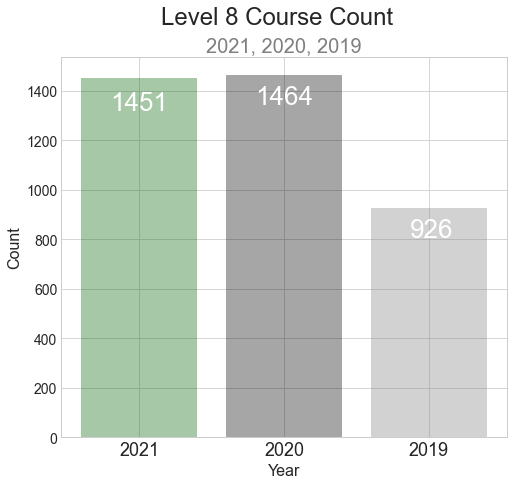

In [67]:
# Set plot style.
plt.style.use('seaborn-whitegrid')

# Create figure & axis.
fig, ax = plt.subplots()

# Change figure size. 
fig.set_size_inches(8, 7)

# Create bars with count for each year.
ax.bar(x=labels, height=count, color=['darkgreen', 'black', 'grey'], alpha=0.35)

# Add axis title.
ax.set_title("2021, 2020, 2019", fontsize=20, color='grey')

# Set figure title. 
fig.suptitle("Level 8 Course Count", fontsize=24)

# Set axes labels.
ax.set_ylabel("Count", fontsize=16)
ax.set_xlabel("Year", fontsize=16)

# Annotate each bar with course count.
ax.annotate(count[0], xy=(-.20, 1320), fontsize=26, color="white")
ax.annotate(count[1], xy=(.8, 1345), fontsize=26, color="white")
ax.annotate(count[2], xy=(1.87, 810), fontsize=26, color="white")

# Increase ticks' label size.
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=14)

# Show plots.
plt.show()

<br>

### Box-plot
***

The boxplot below depicts the minimum, lower quartile, median, upper quartile, and maximum values of the minimum required points per year.

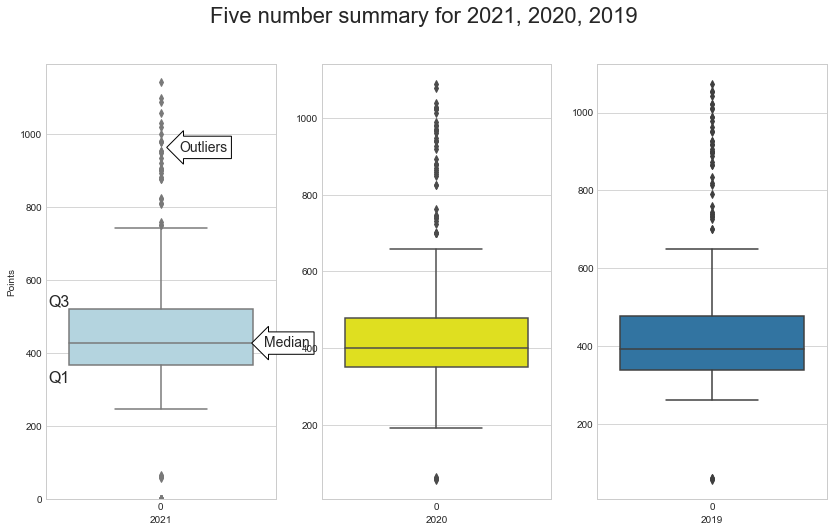

In [141]:
# Set default style.
sns.set_style("whitegrid")

# Create figure & axes.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Change figure size. 
fig.set_size_inches(14, 8)

# Create box plots.
sns.boxplot(ax=ax1, data=mid_21, color="lightblue").set(
            xlabel='2021', 
            ylabel='Points', 
            ylim=(0,1190))

sns.boxplot(ax=ax2, data=mid_20, color="yellow").set(
            xlabel='2020')   

sns.boxplot(ax=ax3, data=mid_19).set(
            xlabel='2019')

# Use plt.text to annotate plots.
ax1.text(x=.01, y=.270, s="Q1", fontsize=16, transform=ax1.transAxes)
ax1.text(x=.01, y=.445, s="Q3", fontsize=16, transform=ax1.transAxes)
ax1.text(x=.95, y=.35, s="Median", fontsize=14, transform=ax1.transAxes,
         bbox=dict(boxstyle="larrow", ec="black", fc="white", lw=1))
ax1.text(x=.58, y=.80, s="Outliers", fontsize=14, transform=ax1.transAxes, 
         bbox=dict(boxstyle="lArrow", ec="black", fc="white", lw=1))


fig.suptitle("Five number summary for 2021, 2020, 2019", fontsize=22)
plt.show();

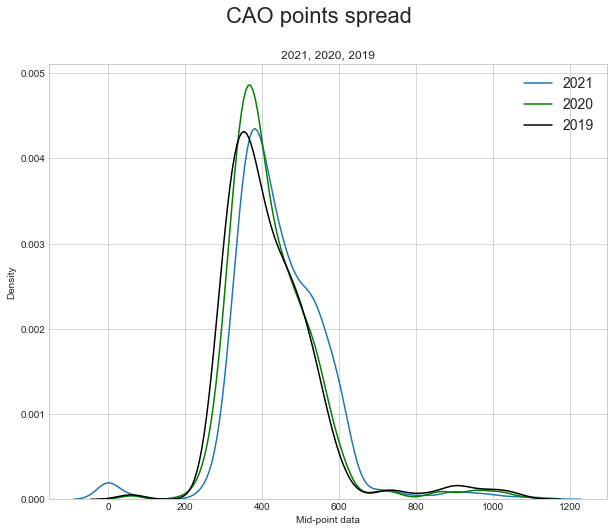

In [119]:
# Create figure & axis.
fig, ax = plt.subplots()

# Change figure size. 
fig.set_size_inches(10, 8)

# Create seaborn kde plots for each year.
sns.kdeplot(mid_21, label=labels[0])
sns.kdeplot(mid_20, label=labels[1], color="green")
sns.kdeplot(mid_19, label=labels[2], color="black")

# Set title/subtitle.
ax.set_title("2021, 2020, 2019")
fig.suptitle("CAO points spread", fontsize=22)

ax.set_xlabel("Mid-point data")
plt.legend(fontsize=14)
plt.show();

Looking at the 2021 mid-point data (red line) and how it has the right-most spread, this tells us that the CAO points requirement has increased significantly, as compared with the previous year's increase. This may be due to grade inflation caused by the implementation of predicted grades for students due to the Covid-19 pandemic.

This gives us a general depiction of how the 2021 points increased significantly. Let's now get a numeric representation of the increase.

<br>

## <center>Comparison Analysis</center>
***

<br>

### Points Increase
***

In this section:

- Create a function to calculate the percentage increase between the years

<br>

The relative change mathematical formula will be used for this end. [http://www.math.utah.edu/~krtolica/3A.pdf] Percentage increase = Increase ÷ Original Number × 100.


#### Relative change - formula:

<br>

<img src="Images/percent_change_formula.svg">

In [70]:
def point_change(col1, col2):
    '''
        Function:
            Calculates increase from two specified years.
        Params:
            col1 : most recent year
            col2 : least recent year
            total : sum of points for recent year
        Returns:
            The increase as a percentage.     
    '''
    total21 = col1.sum()
    x = (col1 - col2).sum()
    
    return round(x / total21 * 100, 2)

In [71]:
# Mid points increase.
print("2020-2021 Increase:", point_change(mid_21, mid_20), "%")
print("2019-2020 Increase:", point_change(mid_20, mid_19), "%")

2020-2021 Increase: 4.55 %
2019-2020 Increase: 2.35 %


<br>

### Calculate the percentages of courses that had an increase/decrease/no change 
***

- https://www.irishtimes.com/news/education/record-breaking-grades-and-high-demand-see-significant-rise-in-cao-points-requirements-1.4667346

Minimum points increase.

In [72]:
x = mid_21 - mid_20
x

0       13.0
1       30.0
2       12.0
3       20.0
4       25.0
        ... 
1686     NaN
1687     NaN
1688     NaN
1689     NaN
1690     NaN
Length: 1691, dtype: float64

value_counts() : returns True & False values in descending order (highest first).
get() : returns the True/False value count

In [73]:
def course_fluctuations(col1, col2):
        '''
        Function:
            Calculates course points fluctuations from two specified years.
        Params:
            col1 : most recent year
            col2 : least recent year
            total : sum of points for recent year
        Returns:
            !!!The increase as a percentage.!!!     
        '''
        diff = col1 - col2
        increase = (diff > 0).value_counts().get(True)
        decrease = (diff < 0).value_counts().get(True)
        no_change = len(col1) - (increase + decrease)
        
        return [increase, decrease, no_change]

In [120]:
# Calculate course points fluctuation.
min_fluc = course_fluctuations(r1_21, r1_20)
mid_fluc = course_fluctuations(mid_21, mid_20)

# Create pandas dataframe.
min_fluc = pd.DataFrame(min_fluc, index=["Increase", "Decrease", "No_change"], columns = ["count"])
mid_fluc = pd.DataFrame(mid_fluc, index=["Increase", "Decrease", "No_change"], columns = ["count"])

# For creating pie chart.
point_list = [min_fluc, mid_fluc]

autopct reference: http://www.learningaboutelectronics.com/Articles/How-to-create-a-pie-chart-in-matplotlib-with-Python.php#:~:text=To%20add%20percentages%20to%20each,percentage%20to%20the%20tenth%20place.

colours that can be used on plots https://matplotlib.org/stable/gallery/color/named_colors.html

Maybe explain parameters used to create pie chart.

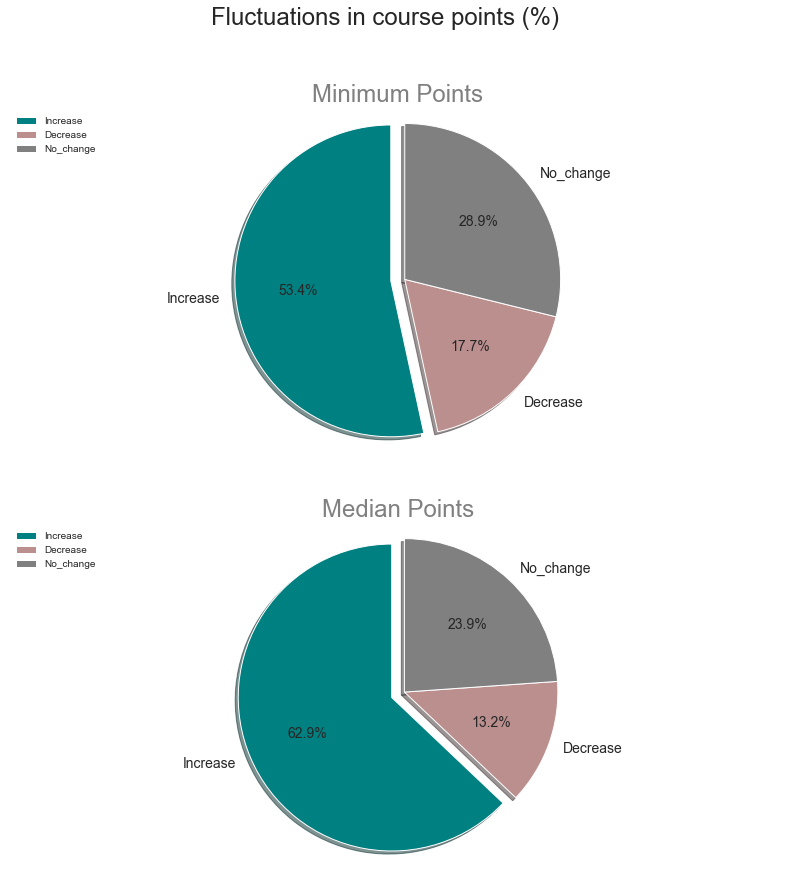

In [121]:
# Set values for explode effect on segments.
explode = [0.09, 0.0, 0.0]

# Create figure & axis.
fig, axes = plt.subplots(2, 1)

# Change figure size. 
fig.set_size_inches(14, 14)

ax = 0
title = ["Minimum Points", "Median Points"]
name = 0
for i in point_list:
    axes[ax].pie(x=i["count"], labels=i.index, 
       colors=["teal", "rosybrown", "grey"], 
       autopct='%1.1f%%', # Displays percentages rather than count.
       shadow=True, 
       explode=explode,
       startangle=90,
       textprops={'fontsize': 14})     # Pivots pie chart 90 degrees.
    axes[ax].axis("equal")
    axes[ax].legend(loc="upper left")
    axes[ax].set_title(title[name], fontsize=24, color="Grey")
    ax += 1
    name += 1
    
fig.suptitle("Fluctuations in course points (%)", fontsize=24)

plt.show();

### Conclusion
***



***
# End